
# Investigating solar installer marketing strategies using natural language processing

This analysis classifies solar installer tweets to better understand what type of marketing they conduct and the frequency that they conduct it. For instance do solar installers conduct more inbound or outbound marketing. And within each type of marketing, which topics are reference d more often.





Useful documents 
- http://miriamposner.com/blog/very-basic-strategies-for-interpreting-results-from-the-topic-modeling-tool/
- https://www.dataquest.io/blog/matplotlib-tutorial/
- http://ieeexplore.ieee.org/xpl/login.jsp?tp=&arnumber=7023421&url=http%3A%2F%2Fieeexplore.ieee.org%2Fxpls%2Fabs_all.jsp%3Farnumber%3D7023421
- http://journals.ama.org/doi/abs/10.1509/jmr.12.0106


# Table of Contents
 <p><div class="lev1"><a href="#The-Goal"><span class="toc-item-num">1&nbsp;&nbsp;</span>The Goal</a></div><div class="lev1"><a href="#Inbound-and-outbound-marketing"><span class="toc-item-num">2&nbsp;&nbsp;</span>Inbound and outbound marketing</a></div><div class="lev1"><a href="#What-is-the-aggregate-breakdown-for-solar-installer-marketing?"><span class="toc-item-num">3&nbsp;&nbsp;</span>What is the aggregate breakdown for solar installer marketing?</a></div><div class="lev1"><a href="#Preprocessing-features-for-NLP-analysis"><span class="toc-item-num">4&nbsp;&nbsp;</span>Preprocessing features for NLP analysis</a></div><div class="lev2"><a href="#Controlling-for-customer-service-communication-in-Tweets."><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Controlling for customer service communication in Tweets.</a></div><div class="lev2"><a href="#Controlling-for-dates-and-times"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Controlling for dates and times</a></div><div class="lev2"><a href="#Replacing-company-name-or-twitter-hashtag-with-a-generic-text"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Replacing company name or twitter hashtag with a generic text</a></div><div class="lev2"><a href="#Replacing-person-name-with-Generic-text"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Replacing person name with Generic text</a></div><div class="lev2"><a href="#Remove-single-word-occurrences"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Remove single word occurrences</a></div><div class="lev2"><a href="#Replace-emails-with-standardized-text"><span class="toc-item-num">4.6&nbsp;&nbsp;</span>Replace emails with standardized text</a></div><div class="lev2"><a href="#Replacing-geographic-region-with-a-text"><span class="toc-item-num">4.7&nbsp;&nbsp;</span>Replacing geographic region with a text</a></div><div class="lev2"><a href="#expand-contractions"><span class="toc-item-num">4.8&nbsp;&nbsp;</span>expand contractions</a></div><div class="lev1"><a href="#Prepare-tf-idf-and-count-vectorizers;-investigate-terms-by-count"><span class="toc-item-num">5&nbsp;&nbsp;</span>Prepare tf-idf and count vectorizers; investigate terms by count</a></div><div class="lev2"><a href="#Review-total-dimensionality-of-the-analysis"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Review total dimensionality of the analysis</a></div><div class="lev1"><a href="#Apply-k-means-clustering-to-determine-topics"><span class="toc-item-num">6&nbsp;&nbsp;</span>Apply k-means clustering to determine topics</a></div><div class="lev1"><a href="#Apply-topic-modeling-with-LDA-and-visualize-with-pyLDAvis-to-adjust-parameters"><span class="toc-item-num">7&nbsp;&nbsp;</span>Apply topic modeling with LDA and visualize with pyLDAvis to adjust parameters</a></div><div class="lev1"><a href="#Investigate-tweet-composition-by-topic"><span class="toc-item-num">8&nbsp;&nbsp;</span>Investigate tweet composition by topic</a></div><div class="lev2"><a href="#What-is-the-trend-in-solar-marketing-over-time?"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>What is the trend in solar marketing over time?</a></div>

In [1]:
%matplotlib inline
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
from textblob import TextBlob as blob
from scipy import stats
import pymysql.cursors
from datetime import datetime, timedelta
import datefinder



#from vaderSentiment.vaderSentiment import sentiment as vaderSentiment 

# sentiment analysis
from textblob.sentiments import NaiveBayesAnalyzer
#from pattern.en import sentiment, mood, modality, wordnet, ADJECTIVE

# text parsing
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from spacy.en import English, STOPWORDS
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tag import pos_tag
from collections import Counter

# modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.cluster import KMeans
import lda
from sklearn.decomposition import PCA, LatentDirichletAllocation

# visualization
import pyLDAvis


import warnings
warnings.filterwarnings("ignore")




/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [4]:
connection = pymysql.connect(host="localhost", user="root", db="twitterresearch")

def query_db(query):
    with connection.cursor() as cursor:
        cursor.execute(query)
        return cursor.fetchall()
# #         result = [item[0] for item in cursor.fetchall()]
#         return result

2. Exploratory Data Analysis

Features investigated:
- 


# Inbound and outbound marketing

What is the industry standard for solar installers? How do they split their solar marketing over time?

While this is good analysis, it does not necessarily reflect the importance of each. Releasing an outbound retweet of someone else tweet is not much effort. Whereas a tweet where the user gives more information about event they will host is fairly time consuming.

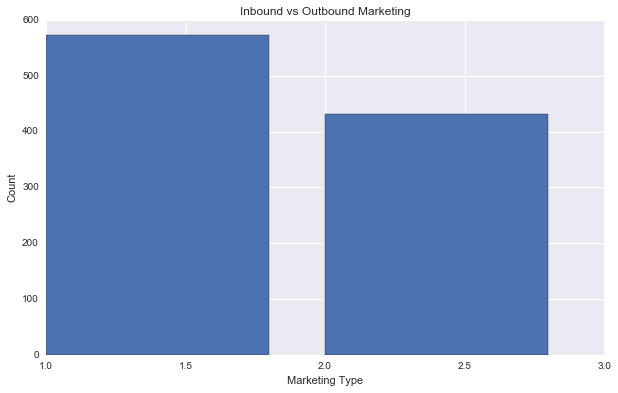

In [5]:
query = """SELECT LEFT(marketing_type , 1), COUNT(*)
            FROM tweets 
            WHERE marketing_type IS NOT NULL
            AND marketing_type NOT IN ('3-a','4-a','5-a')
            GROUP BY LEFT(marketing_type , 1);"""

results = dict(query_db(query))

plt.figure(figsize = (10, 6))
#sns.barplot(results.keys(), 'favorite_count', data = results.values())



plt.bar(results.keys(), results.values(), label='New Chart')
plt.xlabel('Marketing Type')
plt.ylabel('Count')
plt.title("Inbound vs Outbound Marketing");


When did solar installers start using twitter? 

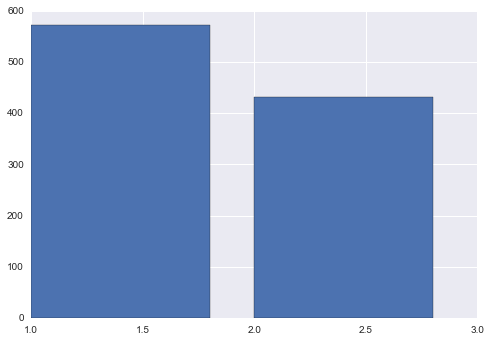

In [6]:
query = """SELECT LEFT(marketing_type , 1), COUNT(*)
            FROM tweets 
            WHERE marketing_type IS NOT NULL
            AND marketing_type NOT IN ('3-a','4-a','5-a')
            GROUP BY LEFT(marketing_type , 1);"""

results = dict(query_db(query))

plt.bar(list(results.keys()), list(results.values()), label='New Chart');


Have solar installers changed over time?

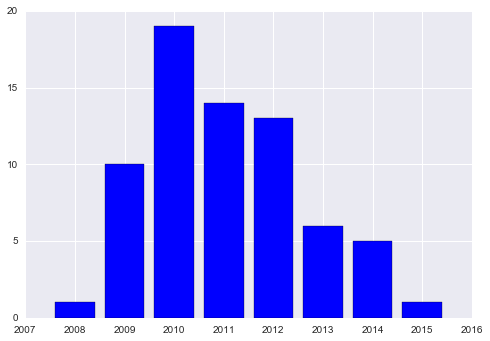

In [28]:
from collections import Counter

query = """SELECT twitter_id_fkey, YEAR(MIN(tweet_date)) FROM tweets
            GROUP BY twitter_id_fkey;"""


results = query_db(query)
results = Counter(dict(sorted(results)).values())

x = list(results.keys())
y = results.values()
width = 1/1.5
plt.bar(x,y, align='center', color="blue")

# get the ticks right
xx, locs = plt.xticks()
ll = ['%.0f' % a for a in xx]
plt.xticks(xx, ll)


plt.savefig('results/twitter_adoption.png')

Are solar installers using twitter more each year?

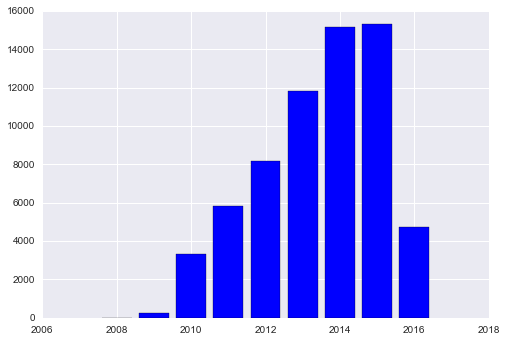

In [29]:
query = """SELECT YEAR(tweet_date), COUNT(*) FROM tweets
            GROUP BY YEAR(tweet_date)
            ;"""

results = dict(query_db(query))
x = list(results.keys())
y = results.values()
width = 1/1.5
plt.bar(x,y, align='center', color="blue")

# get the ticks right
xx, locs = plt.xticks()
ll = ['%.0f' % a for a in xx]
plt.xticks(xx, ll)


plt.savefig('results/number_tweets_by_year.png')

In [9]:
# put tweets into a dataframe
query = """SELECT tweets.tweet, tweets.tweet_date, tweets.retweeted, tweets.retweet_count, tweets.favorited, tweets.favorite_count, installers.installer_name, tweets.marketing_type 
            FROM tweets 
            LEFT JOIN installers 
            ON tweets.twitter_id_fkey = installers.twitter_id"""

results = query_db(query)

tweet, tweet_date, retweeted, retweet_count, favorited, favorite_count, installer_name, marketing_type  = zip(*results)

data = [tweet, tweet_date, retweeted, retweet_count, favorited, favorite_count, installer_name, marketing_type ]

df = pd.DataFrame(data)
df = df.transpose()
cols = ['text', 'tweet_date', 'retweeted', 'retweet_count', 'favorited', 'favorite_count', 'company', 'marketing_type']
df.columns = cols



In [10]:
def add_metadata(df):
    """Add date, is retweet, month, and week features to df."""
    # add date as datetime object
    df.loc[:, 'date'] = df.loc[:, 'tweet_date'].apply(lambda x: pd.to_datetime(x).date())
    
    # add month
    df.loc[:, 'month'] = df.loc[:, 'date'].apply(lambda x: x.replace(day = 1))

In [11]:
add_metadata(df)

Who uses Twitter more?

In [12]:
def plot_time(counted):
    """Plot tweets over time."""
    cands = ['SolarCity']
    plt.figure(figsize = (10, 6))
    for cand in cands:
        plt.plot(counted.loc[cand, 'text'], label = cand)
    plt.legend(loc = 'best')
    plt.show()

Do particular solar installers get retweeted more?


What is the history of their retweets over time?

What are the most retweeted tweets? Is there a common thread? Are they from a particular company? Does that company have something special about them? 

In [13]:
# show original tweets
# df

retweets = df[df['text'].str.contains('RT', na=False) == False]

list_most_retweeted = retweets[['text', 'company', 'retweet_count']].sort_values(['retweet_count'], ascending=False)

Relationship between tweets and revenue?

# What is the aggregate breakdown for solar installer marketing?

This section segments the analysis

# Preprocessing features for NLP analysis

Tweets have 

Define functions to tokenize and add sentiment, modality, and mood scores.

TagLDA: Bringing document structure knowledge into topic models http://pages.cs.wisc.edu/~jerryzhu/pub/taglda.pdf
Content Marketing LDA - https://www.seoreseller.com/blog/content-marketing-through-topic-modeling

Reducing dimensionality
http://fastml.com/dimensionality-reduction-for-sparse-binary-data/

Bag of words implementation

In [14]:
# get only the top tweets for intial analysis
# df = df.head(200)

In [15]:
def get_sentences(text):
    """Return list of sentences in tweet."""
    sents = sent_tokenize(text)
    return [sent for sent in sents if re.search('[a-zA-Z]', sent) != None]

## Controlling for customer service communication in Tweets.

A considerable number of the tweets are user mentions -- Tweets where the user mentions a particular user. These tweets are most likely a customer service. To help better categorize these tweets. We will replace the twitter handle for the person that they are contacting with the text "usermention"

In [16]:
def remove_user_mention(text):
    """
    Add annotation and remove the username to tweets 
    that are user mention. 
    """    
    try: 
        if text[0] == '@' and len(text) > 0:
            try:
                split_tweet = text.split(" ")
                twitter_handle = split_tweet[0]
                text = ' '.join(['usermention' if word==twitter_handle else word for word in split_tweet])
            except Exception as e:
                print(text)
    
    except Exception as e:
        print(text)
    
    return text
     

## Controlling for dates and times

a lot of the tweets reference a particular time or date. This is because they are typically referencing a date or time that an event will be held. These tweets should be grouped together as the date or the time that event occurred is not that important. It is more important to know that there was a particular event held on a date.

- date reference vs time reference 'May 23rd at 8:00am'

TODO:
- what is the difference between personal message (pm) and pm time


In [17]:
def control_datetime(text):
    
    days = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday', 'tomorrow', 'yesterday', 'weekend']
    months = ['january', 'jan', 'february', 'feb', 'march', 'mar', 'april', 'apr', 'may', 'june', 'jun', 'july', 'jul', 'august', 'aug', 'september', 'sep', 'october', 'oct', 'november', 'nov', 'december', 'dec']
#     time = ['pm', 'am', 'noon', 'morning', 'afternoon', 'evening', 'night', 'today']

    for date in (days + months):
        date = r'(?<![a-z])' + date + '(?![a-z])'
        text = re.sub(date, 'datereference', text, flags=re.IGNORECASE)
        
    time = r'\d{1,2}(?:(?:am|pm)|(?::\d{1,2})(?: am| pm)?|(?::\d{1,2})(?:am|pm)?)'
    text = re.sub(time, 'timereference', text, flags=re.IGNORECASE)
    
    return text
    
text = "Tomorrow at 9:00 am until &lt;br /&gt;Sunday, May 23 at 5:00 pm. Come... http://bit.ly/cqi6Lr"
control_datetime(text)
    

'datereference at timereference until &lt;br /&gt;datereference, datereference 23 at timereference. Come... http://bit.ly/cqi6Lr'

## Replacing company name or twitter hashtag with a generic text
a lot of tweets reference particular places


In [18]:
# list of companies

def create_company_list():
    companies = set(df.company.drop_duplicates())
    for c in companies:
        words = u' '.join(c.lower().split(" "))
        words_no_space =  u''.join(words.replace(".","").split(" "))
        companies = companies.union({words, words_no_space})

    companies = companies.union({u'herca',u'hemetsolar', u'solstice', u'vivint solar', u'vivintsolar', u'vivint', u'sunline',  u'trinitysolar', u'trinity', u'rgsenergy', u'rg', u'sullivansolar', u'solare', u'solarenergy',u'recsolar', u'rec', u'sullivan', u'joule', u'thesolarco', u'solaruniverse', u'gci', u'green convergence', u'pacificsolar', u'ross', u'ross group', u'namaste', 'asi hastings', u'asi', u'verengosolar', u'gosolaire', u'solaire', u'sunationsolarchoice', u'sunationsolar', u'acroenergy', u'sunation', u'namast',  u'luminalt', u'solar alliance america', u'quality home improvement', u'solstice story'})
    return companies

companies = create_company_list()

def replace_company_name(text):
    """
    Apply regex to each company name.
    """
    for company in (companies):
        company = r'(?<![a-z])' + company + '(?![a-z])'
        text = re.sub(company, 'companyreference', text, flags=re.IGNORECASE)
    
    return text
    
text = 'join vivint solar today at our event'    
replace_company_name(text)

'join companyreference solar today at our event'

## Replacing person name with Generic text
- http://www.matthewjockers.net/2013/04/12/secret-recipe-for-topic-modeling-themes/

## Remove single word occurrences
Single words could be misspellings or other incidents where 

In [19]:
def remove_single_word_occurrence(texts):
    """
    removes words that only occur once in the total corpu
    """
#     all_tokens = sum(texts, [])
    print(df.tokens.T.ravel())
#     tokens_once = set(word for word in set(all_tokens) if all_tokens.count(word) == 1)
#     texts = [[word for word in text if word not in tokens_once] for text in texts]
#     return texts

In [20]:
def remove_single_word_occurrences(text):
#     num_words = Counter(' '.join(df['tokens'].tolist()).split())
    word_count = Counter(text.split(" "))
    unique_words = [word for word, count in word_count.items() if count == 1]
    
    print(unique_words)


play_text = "energy makeover put on by the blue planet foundation we be happy to help out ready for el ni o for a limited time green convergence will supply a free roof include year manufacturer 's hyperlink just donate $ from our game www solarsfun net to alliance for climate protection 's repower america campaign match at www wecansolveit org csi program forum at solar power at the anaheim convention center on datetime th from pm to pm the hyperlink ever think about enter the solar market here ' your chance hyperlink great news from veep biden and friend at renewable funding for recovery through retrofit hyperlink more on ca 's fee in tariff hyperlink biden solar plan hyperlink last week the governor of statename pass a bill allow solar user to be pay for the excess energy they hyperlink revolusun be happy to donate a p v system to blue planet energy make over show if you miss it tune in to kgmb on the th at p m off to anaheim for solar power international next week @ us if you 're go too rt @dannyksfun"
remove_single_word_occurrences(play_text)

['match', 'roof', 'out', 'off', 'recovery', 'will', 'convention', 'limited', 'too', 'pass', 'go', 'system', 'governor', 'statename', 'here', 'protection', 'repower', 'last', 'fee', 'ever', 'by', 'user', 'kgmb', 'great', 'allow', '@dannyksfun', 'manufacturer', 'v', 'excess', 'funding', 'veep', 'help', 'alliance', 'miss', 'tune', 'it', 'about', 'org', 'through', '$', 'wecansolveit', 'your', 'm', 'international', 'makeover', 'ca', 'free', '@', 'chance', 'revolusun', 'more', 'rt', 'game', 'datetime', 'forum', "'", 'convergence', 'news', 'friend', 'climate', 'center', 'renewable', 'over', 'green', 'bill', 'foundation', 'of', 'they', "'re", 'program', 'we', 'think', 'put', 'el', 'tariff', 'ni', 'ready', 'us', 'year', 'supply', 'o', 'america', 'pay', 'plan', 'solarsfun', 'retrofit', 'show', 'our', 'market', 'next', 'just', 'include', 'campaign', 'net', 'csi', 'and', 'make', 'enter', 'time']


## Replace emails with standardized text

In [21]:
email_pattern = re.compile('([\w\-\.]+@(\w[\w\-]+\.)+[\w\-]+)')

def get_emails(text):
    """Returns an iterator of matched emails found in string s."""
    for match in email_pattern.findall(text):
        
        text = text.replace(match[0], 'useremailaddress')
    
    return text

text = 'this is an emails matt.a.stringer@gmail.com'
get_emails(text)

'this is an emails useremailaddress'

## Replacing geographic region with a text


This looks like a good example. https://pypi.python.org/pypi/geograpy/0.3.7
Package not currently not yet ready for Python3

Current implemtation is only implementing a list of text


In [41]:
states = set(['Alabama', 'AL', 'Alaska', 'AK','Arizona', 'AZ', 'Arkansas', 'AR', 'California', 'CA', 'Colorado', 'CO', 'Connecticut','Delaware', 'DE', 'Florida','FL','Georgia', 'GA', 'Hawaii', "Hawai'i", 'HI', 'Idaho', 'ID', 'Illinois', 'IL', 'Indiana', 'ID', 'Iowa', 'IA', 'Kansas', 'KA', 'Kentucky', 'KY', 'Louisiana', 'LA', 'Maine', 'ME', 'Maryland', 'MD', 'Massachusetts', 'MA', 'Michigan', 'MI', 'Minnesota', 'MN', 'Mississippi', 'MS', 'Missouri', 'MS', 'Montana', 'MT', 'Nebraska','NE', 'Nevada', 'NV', 'New Hampshire', 'NH', 'New Jersey', 'NJ', 'New Mexico', 'NM', 'New York', 'NY', 'North Carolina', 'NC', 'North Dakota', 'ND', 'Ohio','OH',  'Oklahoma','OK','Oregon', 'OR','Pennsylvania','PA', 'Rhode Island','RI', 'South Carolina', 'SC', 'South Dakota','SD', 'Tennessee', 'TN', 'Texas','TX', 'Utah','UT', 'Vermont','VT', 'Virginia','VA', 'Washington','WA', 'West Virginia','WV', 'Wisconsin','WI', 'Wyoming', 'WY' ])
states = states.union({''.join(state.split(" ")) for state in states})

cities = set([ u'athens',u'new orleans', u'san diego', u'san francisco', u'grass valley',  u'santa clarita',u'santa barbara', u'san diego', u'nyc', u'la', u'oakland', u'san jose',  u'bay area', u'los angeles', u'sacramento', u'fresno', u'long island', u'phoenix', u'ca', u'sf', u'marin', u'palm springs', u'sonoma', u'boulder', u'spec city', u'camarillo', u'li', u'seattle', u'austin', u'orange county'])
cities = cities.union({''.join(city.split(" ")) for city in cities})

def replace_geography(text):
    text = replace_states(text)
    text = replace_cities(text)
    return text
    
def replace_states(text):    
    for state in states:
        state = r'(?<![a-z])' + state + '(?![a-z])'
        text = re.sub(state, 'statename', text, flags=re.IGNORECASE)   
    return text

def replace_cities(text):

    for city in cities:
        city = r'(?<![a-z])' + city + '(?![a-z])'
        text = re.sub(city, 'cityname', text, flags=re.IGNORECASE)
    return text
        

text = 'Calcuated 10 $10.8B invested in cleantech in San Francisco, CA in 2008 with 20% increase by matt.a.stringer@gmail.com'
text = replace_geography(text)
print(text)


Calcuated 10 $10.8B invested in cleantech in cityname, statename in 2008 with 20% increase by matt.a.stringer@gmail.com


## expand contractions

In [23]:
nlp = English()
stop = STOPWORDS
punct = {p for p in string.punctuation if p != '@' and p != '#'}

In [24]:
def get_tokens(text):  
    """
    Return lemmatized tokens for each review.
    """
    text = ' '.join(text.lower().split()) # make text lower case
    
    text = get_emails(text) # replace email address
    text = replace_geography(text)
    text = replace_company_name(text)
    
    text = control_datetime(text) # replace dates with str datetimes
    text = remove_user_mention(text) # place replace replies with the names usermentions
    
#     text = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', 'hyperlink', text)# replace urls with str hyperlink
    
    # need to figure out what to do with stuff that points back to their blog or company website
    text = re.sub(r"http\S+", 'hyperlink', text)# replace urls with str hyperlink
    text = re.sub(r"https\S+", 'hyperlink', text)# replace urls with str hyperlink
    text = re.sub(r"www\S+", 'hyperlink', text)# replace urls with str hyperlink 

    words = re.sub("[^a-zA-Z@$%']", " ", text) # remove everything except letters, hashtags, @ and $
    
    
    try:
        tokens = [token.lemma_ for token in nlp(words)] # get lemmas
    except:
        tokens = [token.lemma_ for token in nlp(words.decode('utf8'))] # get lemmas

    filtered = [t for t in tokens if t != '' and t != ' ' and t != '\n' and t != '\n\n'] # remove any remaining spaces
    filtered = [t.strip() for t in filtered] # remove phone numbers from analysis   ?
    filtered = [x for x in filtered if x]

# filtered = [t for t in filtered if any(letter.isalpha() for letter in t)] # remove numbers without any letters attached
    return ' '.join(filtered)



def remove_proper_nouns(text):
    tagged_sent = pos_tag(text.split())
    # [('Michael', 'NNP'), ('Jackson', 'NNP'), ('likes', 'VBZ'), ('to', 'TO'), ('eat', 'VB'), ('at', 'IN'), ('McDonalds', 'NNP')]
    nopropernouns = [word for word,pos in tagged_sent if pos != 'NNP']
    return ' '.join(nopropernouns)


In [25]:

text = "$4.8B wasn't invested in cleantech in San Francisco, california  and Hawai'i 2008 with Sammy's 20% increase by matt.a.stringer@gmail.com http://t.co/asdfasd"
text2 = "RT @AltEnergyWebPar: Residential-solar: Hillary Clinton, Julia Gillard Sign $50 Million Solar Power Pact http://bit.ly/arIegw Full http: ..."
text3 = "RT @BloombergNEF: Excited for today's roundtable w/ @CohnReznickRE in NY to discuss financial innovation in the US renewable industry! http"
text4 = "Hey @greggrunberg check out www.Sungevity.com we're a leading California solar provider and offer free solar quotes via the web in 24 hrs"
text5 = "Tomorrow at 10:00 am until &lt;br /&gt;Sunday, May 23 at 5:00 pm. Come... http://bit.ly/cqi6Lr"
get_tokens(text4)


"hey @greggrunberg check out hyperlink we 're a lead statename solar provider and offer free solar quote via the web in hr"

In [26]:
def get_features(df):
    
    # remove proper nouns from analysis
#     %time df.loc[:, 'text_no_proper_nouns'] = df.loc[:, 'text'].apply(remove_proper_nouns)
    
    
    # add sentences
    %time df.loc[:, 'sentences'] = df.loc[:, 'text'].apply(get_sentences)
    
    # add tokens
    %time df.loc[:, 'tokens'] = df.loc[:, 'text'].apply(get_tokens)
    

    
    # add sentiment, subjectivity, modality, and mood scores by sentence
    #%time df.loc[:, 'sentiment'] = df.loc[:, 'sentences'].apply(get_polarity)
    
    # count number of characters
    %time df.loc[:, 'num_chars'] = df.loc[:, 'tokens'].apply(lambda x: pd.to_numeric(len(x), errors='coerce'))
    
    # count number of tokens
    %time df.loc[:, 'num_tokens'] = df.loc[:, 'tokens'].apply(lambda x: pd.to_numeric(len(x.split()), errors='coerce'))
    
    # count number of hyperlinks
    %time df.loc[:, 'num_hyperlinks'] = df.loc[:, 'tokens'].apply(lambda x: x.split().count('hyperlink'))

In [27]:
get_features(df)

CPU times: user 7.31 s, sys: 54.3 ms, total: 7.36 s
Wall time: 7.39 s
CPU times: user 4min 27s, sys: 1 s, total: 4min 28s
Wall time: 4min 29s
CPU times: user 770 ms, sys: 6.64 ms, total: 777 ms
Wall time: 783 ms
CPU times: user 855 ms, sys: 2.18 ms, total: 857 ms
Wall time: 857 ms
CPU times: user 165 ms, sys: 871 µs, total: 166 ms
Wall time: 166 ms


The top solar installers nationwide - http://www.solarpowerworldonline.com/2014-top-400-solar-contractors/2014-top-100-residential-solar-contractors/

In [30]:
# confirm that we have all the companies on the list

companies = df.company.drop_duplicates()

In [31]:
# only analyze tweets with more than 75 characters
print(len(df))
long_tweets = df[df['num_chars'] > 75.0]

# companies_to_analyze =['Sungevity', 'SolarCity', 'Vivint Solar ', 'SunRun', 'Trinity Solar ', 'Solar Universe Inc.', 'Real Goods Solar ', 'Solar Universe Inc.', 'Alternate Energy Inc']
# long_tweets = long_tweets[long_tweets.company.isin(companies_to_analyze)]
long_tweets = long_tweets[~long_tweets.company.isin(['Quality First Home Improvement Inc.', 'GRID Alternatives'])]
print(len(long_tweets))

64682
43582


In [ ]:
t = long_tweets[long_tweets['tokens'].str.contains('spec city', na=False) == True]
t[['tokens', 'text']].to_csv('out.csv')


In [33]:
# # create list of companies that will be analyzed
# companies = long_tweets.company.drop_duplicates()
# companies

TODO: Pickle for future reloading. Save time on preprocessing

In [34]:
# with open('long_tweetsdf.pkl', 'w') as picklefile:
#     pickle.dump(long_tweets, picklefile)

# Prepare tf-idf and count vectorizers; investigate terms by count

Remove stop words from analysis

In [35]:
# add additional stop words
stop = stop.union({ u'hyperlink', u'rt', u'amp'})

stop = stop.union({u'solar energy', u'solar', u'solar power', u'power', u'energy', u'solarchat', 'ameco'})




A lot of companies use their name. I need to create a stop word for each of the terms.

In [37]:

stop = stop.union({u'ice pop truck'})

# remove the names
stop = stop.union({u'lynn', u'lynn jurich', u'jurich', u'lyndon rive', u'lyndon', u'rive', u'ceo', u'ceo lyndon', u'ceo lyndon rive', u"danny kennedy", u"danny", u"kennedy", u"dannyksfun", u'rainarusso', u'carlsiegrist'})
stop = stop.union(set(open('data/additional_stop_word.txt','r').read().split(",")))


## Review total dimensionality of the analysis

In [38]:
count_vect = CountVectorizer(analyzer = "word", 
                                       tokenizer = None, 
                                       preprocessor = None, 
                                       stop_words = stop, 
                                       ngram_range = (1, 3), 
                                       min_df = 1) 
    
matrix = count_vect.fit_transform(long_tweets.tokens)

print(matrix.shape)

(43582, 462484)


In [39]:
# come back and check min df

def get_word_count(comp, df):
    count_vect = CountVectorizer(analyzer = "word", 
                                       tokenizer = None, 
                                       preprocessor = None, 
                                       stop_words = stop, 
                                       max_features = 10000,
                                       ngram_range = (1, 3), 
                                       min_df = 1) 
    
    matrix = count_vect.fit_transform(df[df.company == comp].tokens)
    grams = count_vect.get_feature_names()
    dist = np.sum(matrix.toarray(), axis = 0)
    grams_sorted = sorted(zip(grams, dist), key = lambda x: x[1], reverse = True)[10:20]
    print('\n', comp, '\n')
    print(grams_sorted)


    

prepare list of most common words for each company

In [42]:
# 

for c in companies:
    try:
        get_word_count(c, long_tweets) 
    except Exception:
        c
    


 Alternate Energy Inc 

[('check', 19), ('electric', 19), ('mitsubishi', 19), ('bia', 17), ('expo', 17), ('heco', 17), ('photo', 17), ('blaisdell', 16), ('happy', 16), ('company', 15)]

 Solar Universe Inc. 

[('usermention', 14), ('cityname', 12), ('new', 12), ('sale', 12), ('day', 10), ('year', 10), ('datereference', 9), ('follow', 9), ('free', 9), ('offer', 9)]

 EmPower Solar  

[('home', 31), ('learn', 29), ('free', 28), ('great', 28), ('join', 25), ('student competition', 25), ('today', 25), ('year', 25), ('check', 24), ('new', 24)]

 RevoluSun 

[('datereference datereference timereference', 102), ('come', 100), ('timereference timereference', 93), ('datereference timereference timereference', 88), ('today', 86), ('house datereference', 81), ('open house datereference', 81), ('oahu', 79), ('sunpower', 68), ('day', 64)]

 Namaste Solar  

[('thank', 28), ('xcel', 27), ('denver', 26), ('program', 26), ('support', 25), ('utility', 25), ('work', 25), ('day', 24), ('help', 24), ('li

# Apply k-means clustering to determine topics

In [43]:
def get_clusters_counts(comp, df, true_k = 5):
    count_vect = CountVectorizer(analyzer = "word", 
                                       tokenizer = None, 
                                       preprocessor = None, 
                                       stop_words = stop, 
                                       max_features = 20000,
                                       ngram_range = (1, 3), 
                                       min_df = 3) 
    

    matrix = count_vect.fit_transform(df[df.company == comp].tokens)
    grams = count_vect.get_feature_names()
    km = KMeans(n_clusters = true_k)
    km.fit(matrix)
    clusters = km.labels_.tolist()
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]
    print('\n', comp)
    for i in range(true_k):
        print("\nCluster %d:" % i)
        print(', '.join([grams[ind] for ind in order_centroids[i, :25]]))
    return km

In [44]:
def get_clusters_tfidf(comp, df, true_k = 5):
    vect = TfidfVectorizer(max_df = 0.5, 
                           max_features = 10000,
                           min_df = 5, 
                           stop_words = stop,
                           use_idf = True, 
                           tokenizer = None, 
                           ngram_range=(1, 3))
    matrix = vect.fit_transform(df[df.company == comp].tokens)
    terms = vect.get_feature_names()
    km = KMeans(n_clusters = true_k)
    km.fit(matrix)
    clusters = km.labels_.tolist()
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]
    print('\n', comp)
    for i in range(true_k):
        print("\nCluster %d:" % i)
        print(', '.join([terms[ind] for ind in order_centroids[i, :25]]))
    return km


In [45]:
#first = get_clusters_counts('SolarCity', long_tweets, 10)

In [46]:
# plot k vs. intertia
inertias = []
for k in range(1, 51):
    mod = get_clusters_counts('SolarCity', long_tweets, k)
    inertias.append(mod.inertia_)


 SolarCity

Cluster 0:
usermention, companyreference, statename, thanks, dm, hear, sorry, thank, stay, time, update, help, sorry hear, usermention sorry, address, new, tune, look, datereference, stay tune, like, news, growth, email, customer

 SolarCity

Cluster 0:
companyreference, statename, new, datereference, year, learn, today, home, job, sun, day, news, panel, join, help, bring, time, insideenergy, late, world, customer, cityname, team, save, want

Cluster 1:
usermention, thanks, dm, hear, statename, sorry, thank, stay, update, sorry hear, usermention sorry, address, time, tune, stay tune, email, usermention sorry hear, usermention thanks, usermention statename, help, growth, like, contact, look, hope

 SolarCity

Cluster 0:
companyreference, statename, new, datereference, year, learn, today, home, job, sun, news, day, panel, join, help, bring, time, late, insideenergy, world, customer, cityname, team, save, want

Cluster 1:
usermention, thanks, dm, hear, sorry, thank, statename

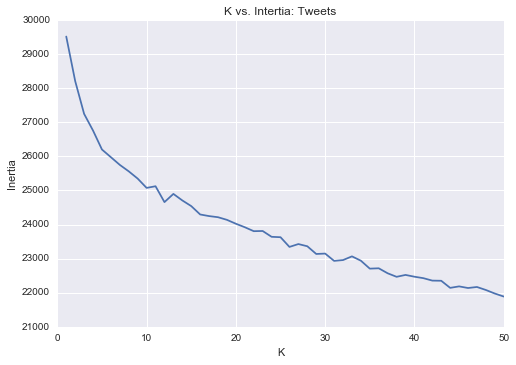

In [47]:
plt.plot(range(1,51), inertias)
plt.title('K vs. Intertia: Tweets')
plt.xlabel('K')
plt.ylabel('Inertia')
plt.show()

With tdidf

In [48]:
# get_clusters_tfidf('SolarCity', long_tweets, 10

In [49]:
# tfidf_inertias = []
# for k in range(1, 51):
#     mod = get_clusters_tfidf('SolarCity', long_tweets, k)
#     tfidf_inertias.append(mod.inertia_)

In [50]:
plt.plot(range(1,51), tfidf_inertias)
plt.title('K vs. TDIDF Intertia: Tweets')
plt.xlabel('K')
plt.ylabel('Inertia')
plt.show()

NameError: name 'tfidf_inertias' is not defined

# Apply topic modeling with LDA and visualize with pyLDAvis to adjust parameters


In [829]:
def print_top_words(model, feature_names, n_top_words = 20):
    """Print top words in each topic."""
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [830]:
def get_doc_topics(doc_topic_dist):
    """Return list of topics for documents, given doc topic distribution"""
    return [np.argmax(topic) for doc, topic in enumerate(doc_topic_dist)]

All tweets; run topic modeling with each tweet as separate document

In [831]:
def get_topics_lda(docs, df, n_topics = 4):   
    count_vect = CountVectorizer(analyzer = "word", 
                                       tokenizer = None, 
                                       preprocessor = None, 
                                       stop_words = stop, 
                                       max_features = 10000,
                                       ngram_range = (1, 5), 
                                       min_df = 10) 
    matrix = count_vect.fit_transform(docs)
    vocab = count_vect.get_feature_names()
    
    # fit transform lda
    lda = LatentDirichletAllocation(n_topics=n_topics, doc_topic_prior = .001, max_iter=5,
                learning_method='online', learning_offset=50.,
                random_state=0)
    doc_topic_dists = lda.fit_transform(matrix)
    

#     print("\nTopics in LDA model:", cand)
#     print_top_words(lda, vocab)
    
    # prepare pyLDAvis stuff 
    get_normed = lambda data: pd.DataFrame(data).div(data.sum(axis = 1), axis = 0) 
    prepared = pyLDAvis.prepare(
            doc_lengths = docs.str.len(),
            vocab = vocab,
            term_frequency = np.asarray(matrix.sum(axis = 0)).ravel().tolist(),
            topic_term_dists = get_normed(lda.components_), # topics x terms 
            doc_topic_dists = get_normed(doc_topic_dists)) # docs x topics 
    
    return lda, vocab, doc_topic_dists, prepared

In [1046]:
# with tf-idf
def get_topics_lda_tfidf(docs, df, n_topics = 4):   
    vect = TfidfVectorizer(max_df = 0.8, 
                           max_features = 200000,
                           min_df = 5, 
                           stop_words = stop,
                           use_idf = True, 
                           tokenizer = None, 
                           ngram_range=(1, 3))
    
    matrix = vect.fit_transform(docs)
    vocab = vect.get_feature_names()
    
    # fit transform lda
    lda = LatentDirichletAllocation(n_topics=n_topics, doc_topic_prior = .001, max_iter=20,
                learning_method='online', learning_offset=50.,
                random_state=0)
    doc_topic_dists = lda.fit_transform(matrix)
    

    
    # prepare pyLDAvis stuff 
    get_normed = lambda data: pd.DataFrame(data).div(data.sum(axis = 1), axis = 0) 
    prepared = pyLDAvis.prepare(
            doc_lengths = docs.str.len(),
            vocab = vocab,
            term_frequency = np.asarray(matrix.sum(axis = 0)).ravel().tolist(),
            topic_term_dists = get_normed(lda.components_), # topics x terms 
            doc_topic_dists = get_normed(doc_topic_dists)) # docs x topics 
    
    return lda, vocab, doc_topic_dists, prepared
    
    

In [757]:
all_lda, vocab, all_doc_topics, all_prepared= get_topics_lda(long_tweets.tokens, long_tweets, 20)

Using TFIDF

In [1148]:
all_lda_tfidf, vocab_tfidf, all_doc_topics_tfidf, all_prepared_tfidf = get_topics_lda_tfidf(long_tweets.tokens, long_tweets, 15)
print_top_words(all_lda_tfidf, vocab_tfidf)




Topic #0:
article, carbon, companyreference instal, renewable, account, grow, wind, generation, set, agree, record, fast, non, field, south, intersolar, usermention thank, nearly, enphase, profit

Topic #1:
best, vote, plant, award, link, green, potential, concern, science, jeff, cityname, win, array, drought, san, large, propose, child, honor, click

Topic #2:
solarpowerworld, youtube, amazing, video, board, sector, release, companyreference customer, nasa, buy, companyreference, pump, webinar, float, save, completely, corporation, series, video youtube, playlist

Topic #3:
usermention, thanks, statename, climate, hear, change, good, great, sorry, thank, love, companyreference, help, happy, time, usermention thanks, stay, like, let, climate change

Topic #4:
statename, companyreference, home, new, panel, gosolar, clean, cityname, look, business, great, share, like, work, customer, investment, electricity, usermention, use, datereference

Topic #5:
kw, instal, size, purchase, spec, ho

In [470]:
#Identify which terms have the highest occurrence and weight across all company descriptions
# all_lda_tfidf.sum()
# word_weight_tfidf = all_lda_tfidf.sum().reset_index()
# word_weight_tfidf.columns = ['word', 'weight']
# word_weight_tfidf = word_weight_tfidf.sort_values(by = 'weight', ascending = False)
vocab_tfidf

AttributeError: 'LatentDirichletAllocation' object has no attribute 'sum'

In [836]:
pyLDAvis.display(all_prepared_tfidf)

In [837]:
tweet_topics = get_doc_topics(all_doc_topics_tfidf)


In [838]:
long_tweets['topic'] = tweet_topics
# show 
# long_tweets[['text','tokens', 'topic']].head(20)

# Investigate tweet composition by topic

- Export formatted data to create d3.js charts of:
- Topics over time by candidate (streamgraph)
- Topics over time by topic (stacked bar chart)
- Sentiment over time (grouped bar chart)
- Imperativeness/call to action percentage over time (grouped bar chart)

In [839]:
bymonth_topic = long_tweets.groupby(['company', 'topic', 'month'])

In [876]:

def get_list_time(df):

    return df[df.month >= pd.to_datetime('2010-01-01').date()].month.drop_duplicates().sort_values().tolist()

def get_topics(df, column_name):
    return df[column_name].drop_duplicates().sort_values().tolist()


In [877]:
def make_analysis_array(df, grouping):
    import collections
    df = df[['month', grouping]]
    df = df[df[grouping].notnull() ]
    
    data = []

    for topic, group in df.groupby(grouping):

        topic_month_count = dict(group['month'].value_counts())

        complete_topic_month_count = { month: topic_month_count[month] if month in topic_month_count else 0 for month in months_in_analysis }
        assert len(complete_topic_month_count) == len(months_in_analysis)

        new_row = np.array([complete_topic_month_count[month] for month in sorted(complete_topic_month_count)])

        data.append(new_row)

    return np.array(data)

In [878]:
def make_stacked_line_chart(x,y,topics, filename):
    y_stack = np.cumsum(y, axis=0)   # a 3x10 array
    fig = plt.figure(figsize=(15,7))
    ax1 = fig.add_subplot(111)

    list_of_colors = ["#CC6666", "#1DACD6", "#6E5160", "#181B2D", "#565762", "#40353D", "#A29FA6", "#C66C1F", "#D5C71F", "#3B9DFF", "#6295A8", "#7CC8FF", "#6D4D17"]

    for t in range(len(topics))[:10]:
        if t == 0:
            ax1.fill_between(x, 0, y_stack[0,:], facecolor="#CC6666", alpha=.7, label=topics[t])
        else:
            ax1.fill_between(x, y_stack[t-1,:], y_stack[t,:], facecolor=list_of_colors[t], alpha=.7, label=topics[t])
    
    handles, labels = ax1.get_legend_handles_labels()

    # reverse the order
    ax1.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
    
    plt.savefig(filename)

## What is the trend in solar marketing over time?

What groups appear more often? When do they appear? 

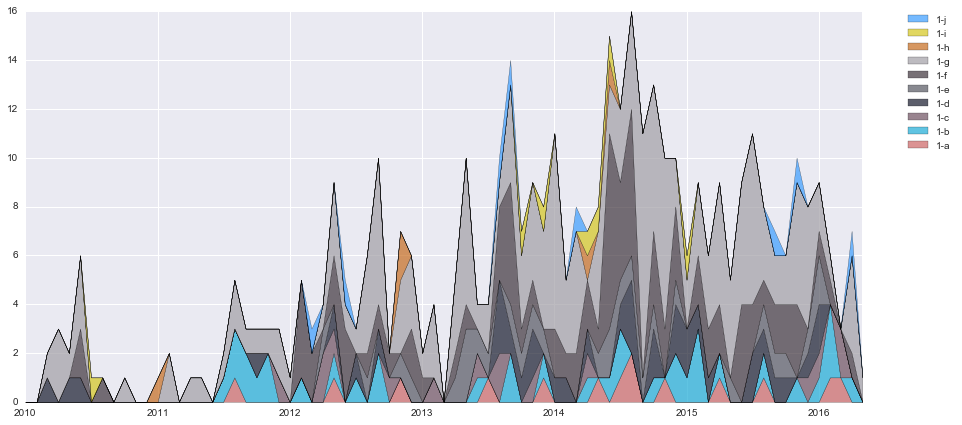

In [879]:
x = get_list_time(long_tweets)
y = make_analysis_array(long_tweets, 'marketing_type')
topics = get_topics(long_tweets, 'marketing_type')
make_stacked_line_chart(x,y,topics, 'marketing_type.png')

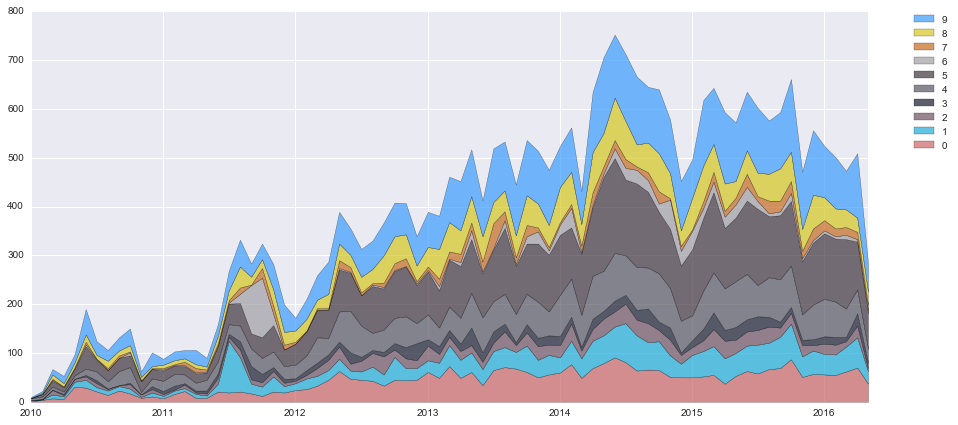

In [880]:
x = get_list_time(long_tweets)
y = make_analysis_array(long_tweets, 'topic')
topics = get_topics(long_tweets, 'topic')
make_stacked_line_chart(x,y,topics, 'lda_topic_model_overtime.png')

Show the clusters.

In [881]:
print_top_words(all_lda_tfidf, vocab_tfidf)


Topic #0:
alliance, blog, new, america, alliance america, home, installation, post, check, review, tune, air, stay, statename, blog post, fight, instal, star, switch, stay tune

Topic #1:
save, way, free, sun, home, know, money, save money, quote, answer, usermention, az, use, let, question, time, ice, check, help, sunshine

Topic #2:
array, produce, communitysolar, instal, panel, inverter, roof, photo, kw, tbt, module, complete, installation, concern, facebook, cell, minute, director, school, project

Topic #3:
hire, video, solarjobs, youtube, job, look, solarimpulse, sale, plane, installers, whitehouse, look like, level, flight, like, neighborhood, harvestsomesun, manager, position, team

Topic #4:
storage, electric, congrats, statename, award, ev, world, plant, battery, car, large, vote, company, best, congratulation, win, charge, new, innovation, vehicle

Topic #5:
statename, year, renewable, new, renewables, grow, industry, electricity, state, job, grid, fuel, water, seia, source

More info

- https://pyldavis.readthedocs.org
- http://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf
- https://cran.r-project.org/web/packages/LDAvis/vignettes/details.pdf


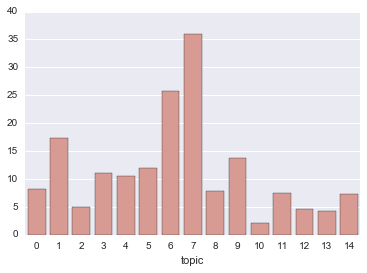

In [919]:
# long_tweets.groupby('topic')['retweet_count'].mean()
topic_to_mean_retweet = long_tweets.groupby('topic')['retweet_count'].sum() / long_tweets.groupby('topic')['retweet_count'].count()




# df_mean_retweet.cols = ['topic', 'mean']

ax = sns.barplot(x=topic_to_mean_retweet.index, y=topic_to_mean_retweet.values,color="salmon", saturation=.5)
ax.figure.savefig('avg_retweets_by_topics.png')


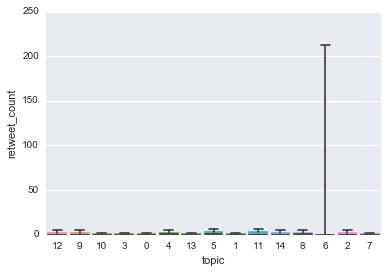

In [939]:
# ax = sns.boxplot(x=long_tweets["topic"])
long_tweets['retweet_count']= long_tweets['retweet_count'].astype(float)

df_box_plot = long_tweets[~(np.abs(long_tweets.retweet_count-long_tweets.retweet_count.mean())>(3*long_tweets.retweet_count.std()))]

ax = sns.boxplot(x="topic", y="retweet_count", data=df_box_plot, showfliers=False)

